## Aircraft,Ship and cars

In [1]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00


Para este projeto a ideia inicial e realizar o processamento de imagem , conseguindo diferenciar um avião, de um carro e de um barco com processamento de imagem, o projeto foi inspirado no problema de birds and non-birds , porém, tentando adicionar a complexidade de tipos bem mais semelhrantes, com 3 variaveis.

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Now let's do the same with "forest photos":

Searching for 'aircraft photos'


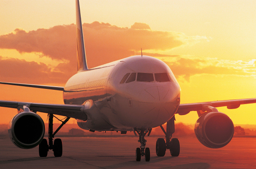

In [5]:
from fastdownload import download_url
from fastai.vision.all import *
download_url(search_images('aircraft photos', max_images=1)[0], 'aircraft.jpg', show_progress=False)
Image.open('aircraft.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'aircraft','car','ship'
path = Path('vehicle')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'aircraft photo'
Searching for 'aircraft sun photo'
Searching for 'aircraft shade photo'
Searching for 'car photo'
Searching for 'car sun photo'
Searching for 'car shade photo'
Searching for 'ship photo'
Searching for 'ship sun photo'
Searching for 'ship shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

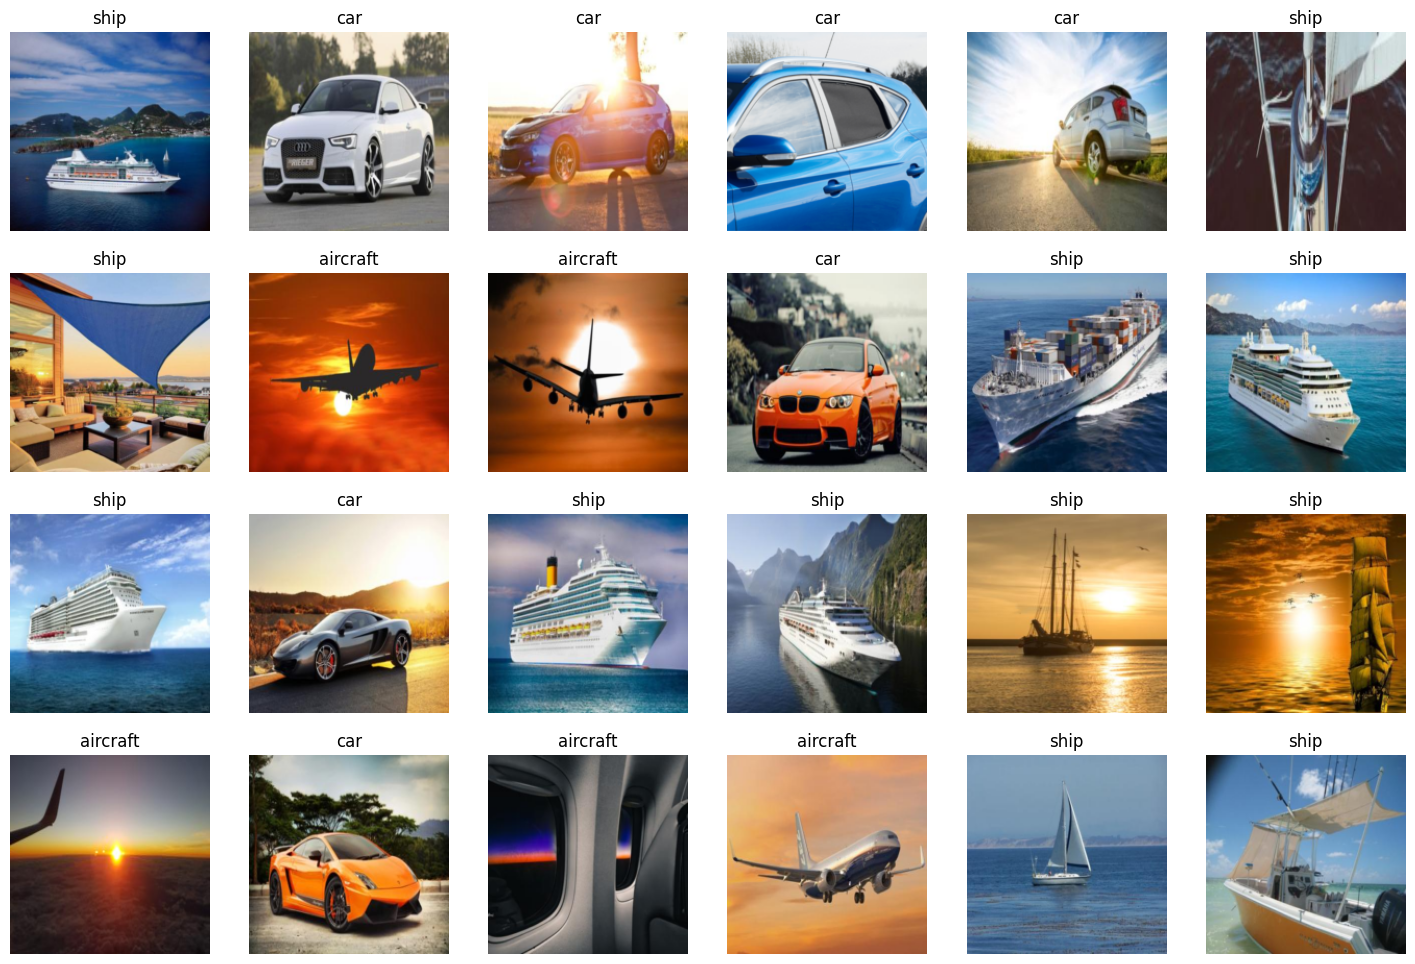

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=24)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.946530,0.946694,0.285714,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.597877,0.655257,0.183673,00:40
1,0.420293,0.483644,0.142857,00:39
2,0.287289,0.417739,0.183673,00:39
3,0.208501,0.405857,0.163265,00:39
4,0.163411,0.397844,0.163265,00:40
5,0.135926,0.371770,0.183673,00:40


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [13]:
model_type,_,probs = learn.predict(PILImage.create('aircraft.jpg'))
print(f"This is a: {model_type}.")
print(f"Probability it's a {model_type}: {probs[0]:.4f}")

This is a: aircraft.
Probability it's a aircraft: 0.9994
